In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?
*  include logger

Epoch 0: Training loss 10.8040, Validation loss 13.1562, learning rate 0.00100
		eadd_loss = -0.6630 vadd_loss = -0.6576
		Validation MAE: 14.2841
Epoch 5: Training loss 4.1792, Validation loss 14.1583, learning rate 0.00100
		eadd_loss = -0.4869 vadd_loss = -0.5826
		Validation MAE: 15.1973
Epoch 10: Training loss 3.0947, Validation loss 14.3456, learning rate 0.00100
		eadd_loss = -0.3549 vadd_loss = -0.4571
		Validation MAE: 15.2354
Epoch 15: Training loss 2.4035, Validation loss 14.3368, learning rate 0.00100
		eadd_loss = -0.2196 vadd_loss = -0.2999
		Validation MAE: 15.0874
Epoch 20: Training loss 2.1319, Validation loss 14.0724, learning rate 0.00100
		eadd_loss = -0.2050 vadd_loss = -0.3075
		Validation MAE: 14.8024
Epoch 25: Training loss 2.0235, Validation loss 13.9061, learning rate 0.00100
		eadd_loss = -0.1717 vadd_loss = -0.2564
		Validation MAE: 14.5875
Epoch 30: Training loss 1.6118, Validation loss 13.7838, learning rate 0.00100
		eadd_loss = -0.1538 vadd_loss = -0.242

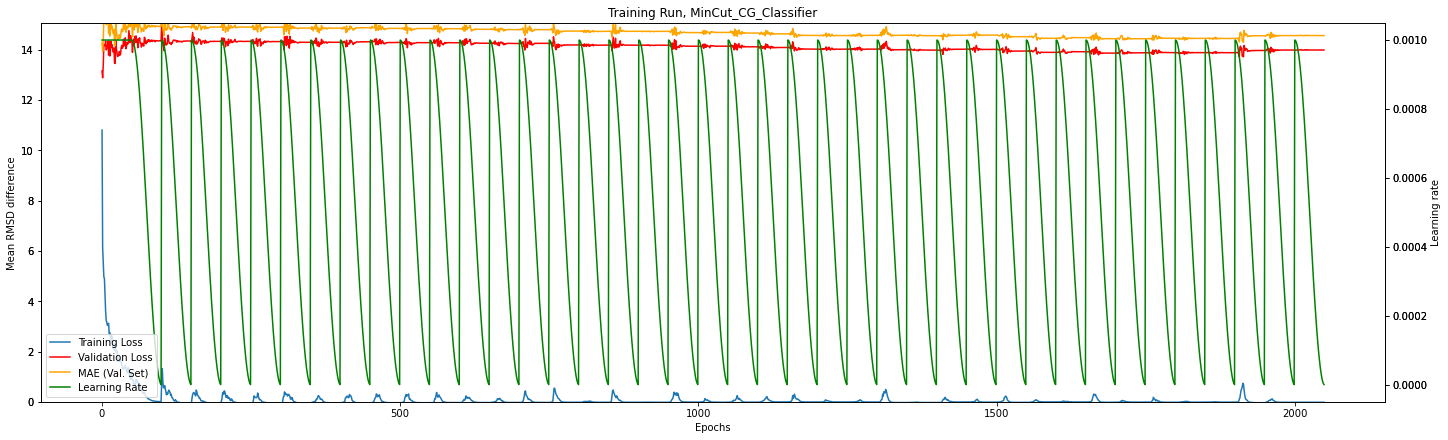

In [8]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=2000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    burn_in=50)

In [9]:
#get training run data

run_dir = "run_data/2022-05-04_15-57_MinCut_CG_Classifier"

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss -0.0539 in epoch 299
Minimum Validation Loss (after 50 epochs) 13.7153 in epoch 1914
Minimum MAE (after 50 epochs) 14.2919 in epoch 1914


Validation Loss at 1914 is 13.7153
5 before select
14.1423, 13.9848, 14.0593, 13.7407, 13.7784
5 after select
14.1687, 14.0610, 13.9726, 14.0506, 14.0186
MAE at 1914 is 14.2919


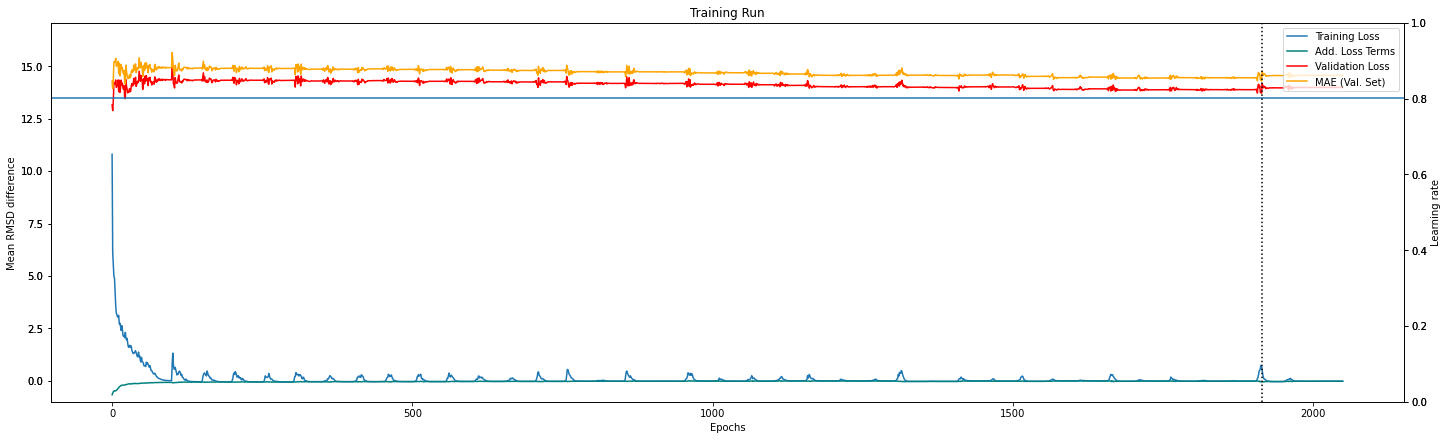

In [15]:
#plot the training run
select = 1914
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=-1, upper=max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13.5)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Test Set
tensor([[19.3690]], device='cuda:0') tensor([[19.4111]], device='cuda:0') 0.0008856008644215763
tensor([[0.]], device='cuda:0') tensor([[25.4506]], device='cuda:0') 24.95055389404297
Mean Test loss: 	 11.8866
Std. Dev. of Test loss:  7.0732
Min loss: 		 0.0009
First Quantile: 	 6.2431
Median: 		 10.8432
Third Quantile: 	 18.5686
Max Loss: 		 24.9506
LinregressResult(slope=-0.38683826792213943, intercept=24.59040223803552, rvalue=-0.13396244236913227, pvalue=0.02577693811958588, stderr=0.17256301689380305, intercept_stderr=3.549583415208308)


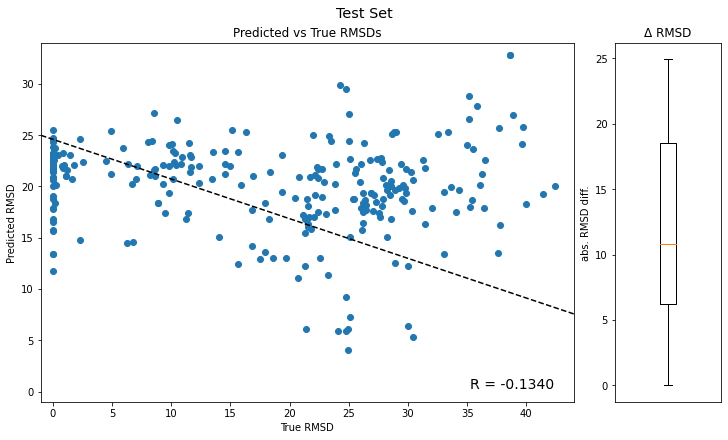

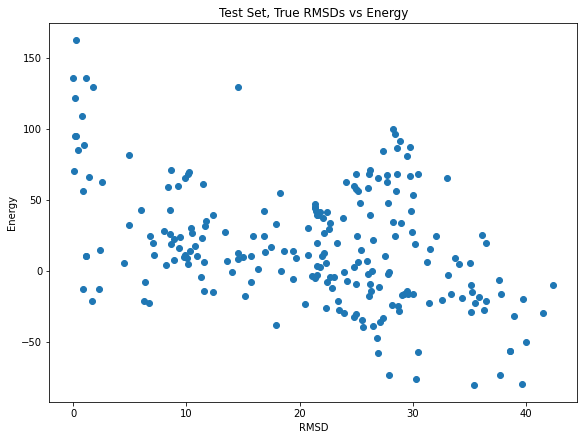

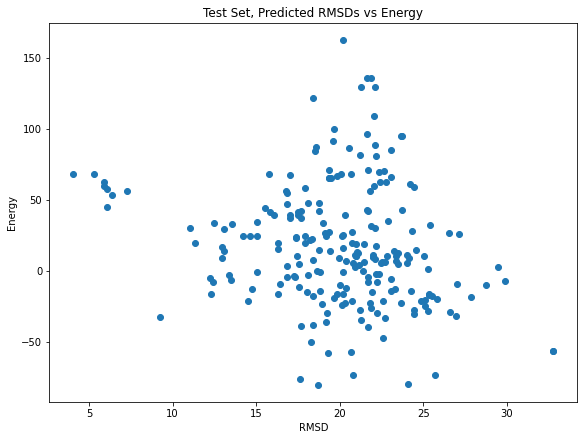

5S and tRNA Test Set
tensor([[19.6280]], device='cuda:0') tensor([[19.6277]], device='cuda:0') 4.4836269808001816e-08
tensor([[0.]], device='cuda:0') tensor([[26.9750]], device='cuda:0') 26.475004196166992
Mean Test loss: 	 3.8158
Std. Dev. of Test loss:  4.4759
Min loss: 		 0.0000
First Quantile: 	 0.7674
Median: 		 2.3398
Third Quantile: 	 5.0590
Max Loss: 		 26.4750
LinregressResult(slope=0.8715573174157745, intercept=0.8956363880435649, rvalue=0.7405351549414765, pvalue=8.194955043914234e-189, stderr=0.024055704912051588, intercept_stderr=0.45236846274936343)


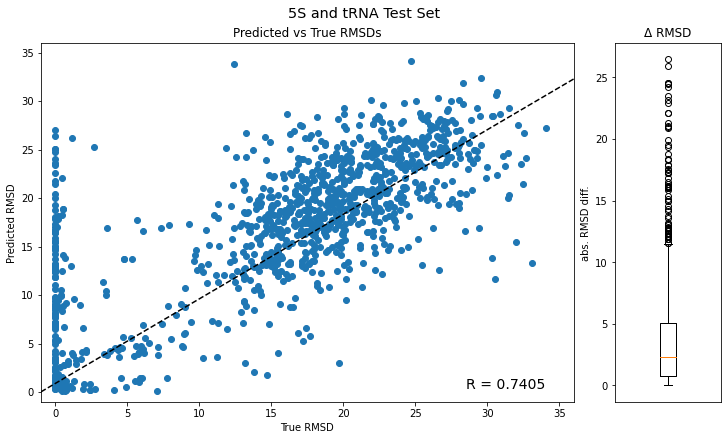

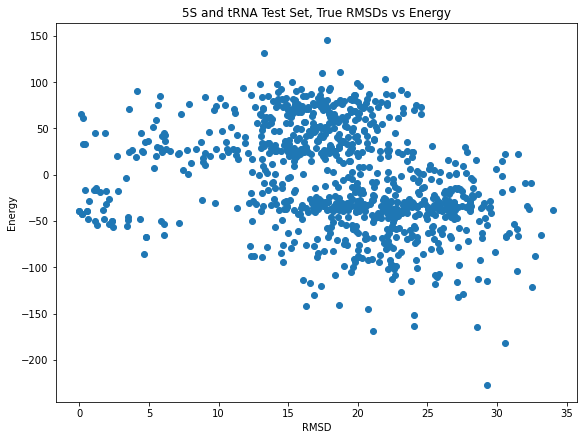

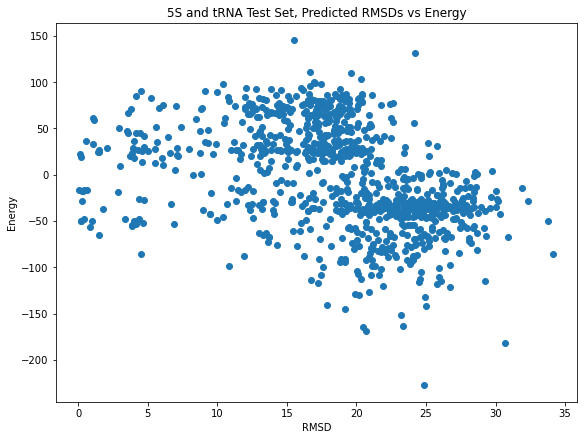

tensor([[0.]], device='cuda:0') tensor([[-0.1802]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.1802]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.0285]], device='cuda:0')
tensor([[0.0330]], device='cuda:0') tensor([[-0.1196]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.0285]], device='cuda:0')
tensor([[0.]], device='cuda:0') tensor([[-0.0285]], device='cuda:0')
tensor([[0.0340]], device='cuda:0') tensor([[-0.1190]], device='cuda:0')
Training Set
tensor([[29.1730]], device='cuda:0') tensor([[29.1719]], device='cuda:0') 5.8891782828141e-07
tensor([[0.]], device='cuda:0') tensor([[10.1521]], device='cuda:0') 9.652100563049316
Mean Test loss: 	 0.5549
Std. Dev. of Test loss:  0.9207
Min loss: 		 0.0000
First Quantile: 	 0.0458
Median: 		 0.2329
Third Quantile: 	 0.7358
Max Loss: 		 9.6521
LinregressResult(slope=0.9896641972742247, intercept=0.13008978435673768, rvalue=0.988979127678034, pvalue=0.0, stderr=0.005381325089227174, intercept

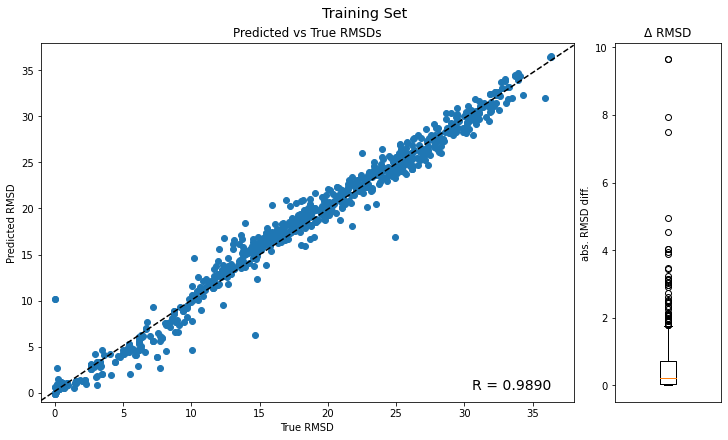

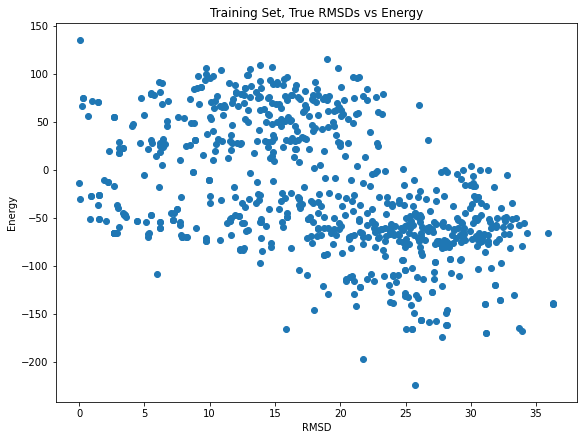

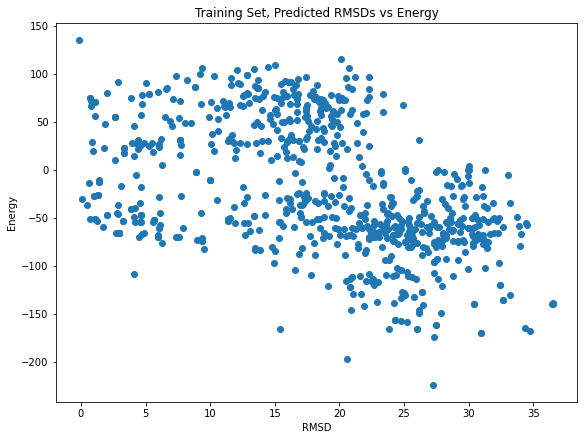

Validation Set
tensor([[17.3870]], device='cuda:0') tensor([[17.3860]], device='cuda:0') 4.994508344680071e-07
tensor([[55.7510]], device='cuda:0') tensor([[10.6397]], device='cuda:0') 44.611297607421875
Mean Test loss: 	 13.5990
Std. Dev. of Test loss:  9.8452
Min loss: 		 0.0000
First Quantile: 	 4.6164
Median: 		 12.7139
Third Quantile: 	 20.4271
Max Loss: 		 44.6113
LinregressResult(slope=-0.004820742092071973, intercept=23.34309528082243, rvalue=-0.0016288705662664822, pvalue=0.9742235025900183, stderr=0.14910034034423497, intercept_stderr=3.132229311610037)


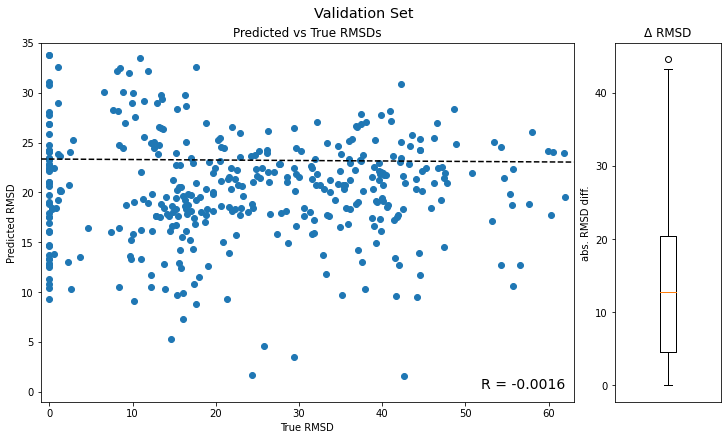

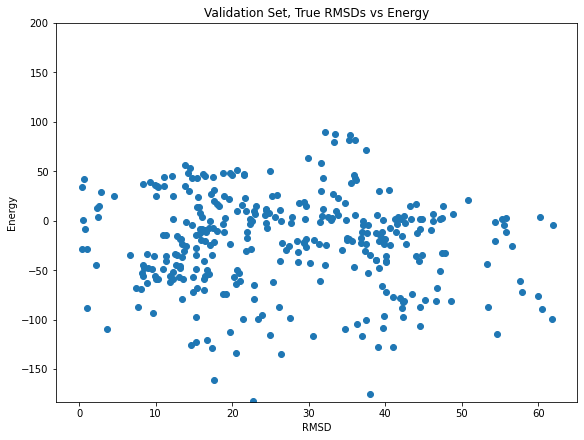

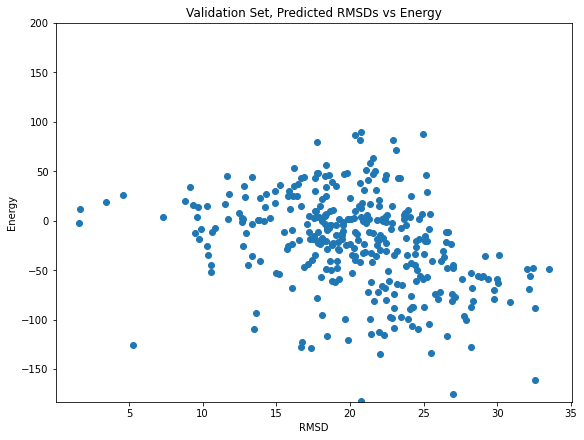

LinregressResult(slope=0.5672734450212985, intercept=9.902007522793689, rvalue=0.3402443777577485, pvalue=1.0014590537402367e-41, stderr=0.04062914606377869, intercept_stderr=0.8198136199219065)


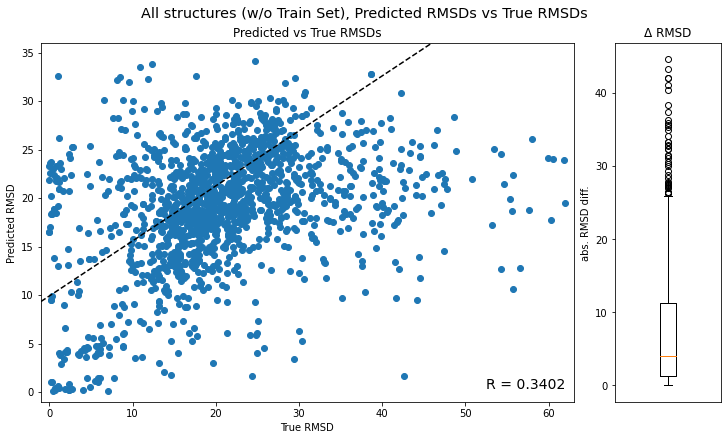

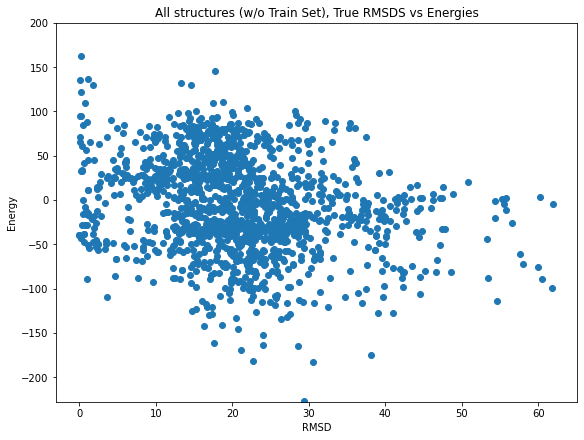

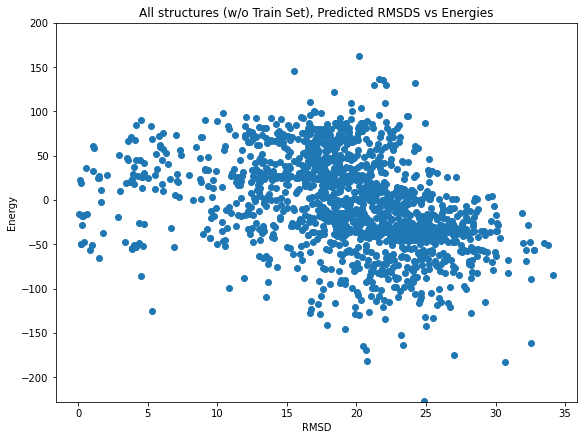

In [14]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    model = DMoN_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load(f"{run_dir}/model_data/epoch_{select}.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9613431839154103, intercept=0.6359391834732229, rvalue=0.9731979250219418, pvalue=1.4213860799272863e-177, stderr=0.013698734992822566, intercept_stderr=0.2608093544045819)


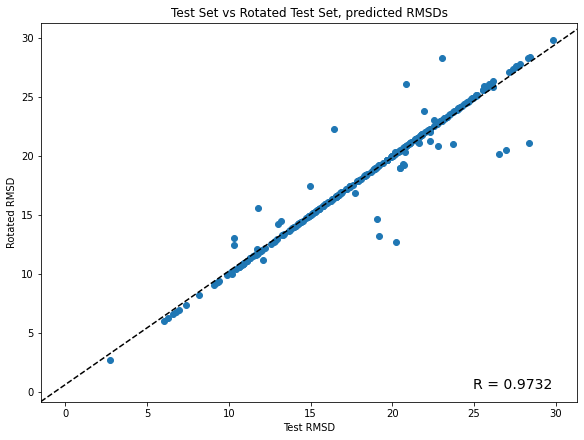

LinregressResult(slope=0.9698713552931753, intercept=0.29378009503368574, rvalue=0.9849994460332203, pvalue=7.001673617710147e-212, stderr=0.010245794559160346, intercept_stderr=0.14333904885535842)


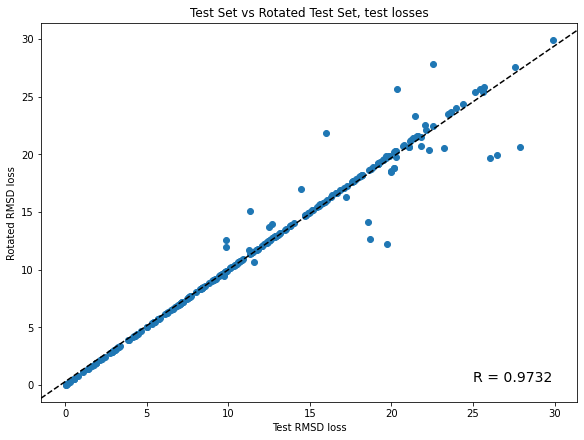

LinregressResult(slope=0.9710701439694108, intercept=0.49223234377970826, rvalue=0.961781580468868, pvalue=0.0, stderr=0.008408586328454771, intercept_stderr=0.1545759180521105)


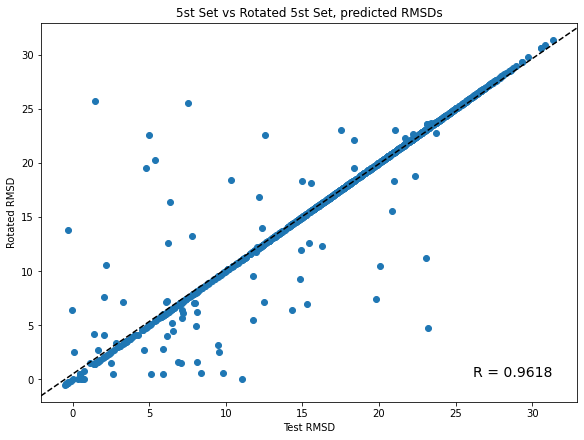

LinregressResult(slope=0.9274470151824533, intercept=0.2892287742747892, rvalue=0.9054321206127754, pvalue=0.0, stderr=0.01322479442741053, intercept_stderr=0.07808287355153815)


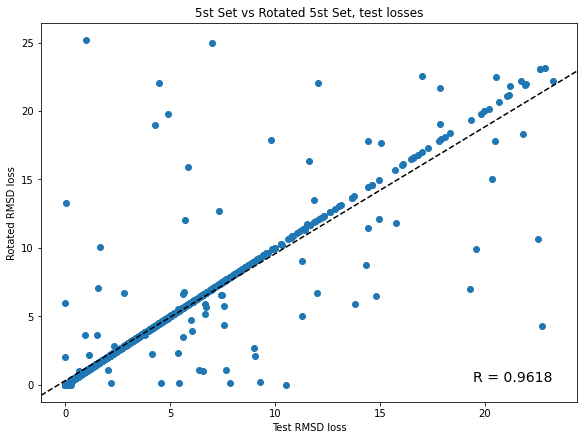

In [7]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")